In [1]:
import classy as Class
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle as pkl
import os
from datetime import datetime
from IPython.display import display, clear_output

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
#plt.rcParams['text.usetex']=True
fsize=16

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

As = 2.100549e-9
ln10e10As = np.log(1e10*As)

standard_params = {
    "omega_b": 0.0223828,
    "omega_cdm": 0.1201075,
    "n_s": 0.9660499,
    "tau_reio": 0.05430842,
    "ln10^{10}A_s": ln10e10As,
    #"100*theta_s": 1.04,
    "H0": 67.32117
}

common_settings = {'output' : 'tCl,pCl,lCl,mPk',
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'modes': "s",
                   'lensing': 'yes',
                   'xe_pert_type': 'none',
                   'N_ur': 2.0308,
                   'N_ncdm': 1,
                   'm_ncdm': 0.06,
                   'T_ncdm': 0.71611, #1 species of massive neutrinos
                  }

In [2]:
def compute_spectra(precision_settings, ll_max_request=4000):
    class_settings = {}
    class_settings.update(common_settings)
    class_settings.update(standard_params)
    class_settings.update(precision_settings)
    M = Class.Class()
    tic = time.perf_counter()
    M.set(class_settings)
    M.compute()
    toc = time.perf_counter()

    Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
    muK2 = (Tcmb)**2

    ######################################################
    # Computing fiducial spectra
    ######################################################
    result_dict = {}
    result_dict["tt"] =  muK2*M.lensed_cl(ll_max_request)['tt'][2:]
    result_dict["te"] =  muK2*M.lensed_cl(ll_max_request)['te'][2:]
    result_dict["ee"] =  muK2*M.lensed_cl(ll_max_request)['ee'][2:]
    result_dict["pp"] =  M.lensed_cl(ll_max_request)['pp'][2:]
    result_dict["settings"] = precision_settings
    result_dict["settings"]["s"] = toc-tic

    M.struct_cleanup()

    return result_dict

def error_plots(fig, dict_list, ref, ll_max_plot=4000):

    gs = mpl.gridspec.GridSpec(nrows=2, ncols=5)
    gs.update(wspace=0, hspace=0.0)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax4 = fig.add_subplot(gs[1, 2:4])
    plot_axes = [ax1, ax2, ax3, ax4]
    info_ax = fig.add_subplot(gs[:, 4])
    info_ax.axis("off")
    ll=np.arange(2, ll_max_plot+1)

    r = fig.canvas.get_renderer()

    text_ypos = 0.05
    for i, result_dict in enumerate(dict_list):
        
        ax1.plot(ll, (result_dict["tt"]-ref["tt"][:ll_max_plot])/ref["tt"][:ll_max_plot])
        ax2.plot(ll, (result_dict["ee"]-ref["ee"][:ll_max_plot])/ref["ee"][:ll_max_plot])
        ax3.plot(ll, (result_dict["te"]-ref["te"][:ll_max_plot])/ref["te"][:ll_max_plot])
        l1, = ax4.plot(ll, (result_dict["pp"]-ref["pp"][:ll_max_plot])/ref["pp"][:ll_max_plot])
        outstring = create_label(result_dict["settings"], i)
        plt.rcParams["font.family"] = "monospace"
        plt.rcParams["font.monospace"] = ["DejaVu Sans Mono"]
        t = info_ax.text(0.1, text_ypos, outstring, color=l1.get_color())
        bb = t.get_window_extent(renderer=r).transformed(info_ax.transData.inverted())
        text_ypos+=bb.height

    for i,ax in enumerate(plot_axes):
        ax.set_ylim([-0.02, 0.02])
        ax.axhline(-0.01, linestyle="dashed", color="gray")
        ax.axhline(0.01, linestyle="dashed", color="gray")
        ax.axvline(4000, linestyle="dashed", color="gray")
        ax.tick_params(axis = 'both', which = 'major', direction="in", labelsize = 8)
        ax.tick_params(axis = 'both', which = 'minor', direction="in", labelsize = 0)
        if i%2!=0:
            ax.tick_params(labelleft=False) 

    return info_ax

def create_label(settings, num):
    outstring = "Settings {}\n".format(int(num))
    for key,value in settings.items():
        if isinstance(value, str):
            outstring+="{0} = {1}\n".format(key, value)
        else:
            outstring+="{0} = {1:.3f}\n".format(key, value)

    return outstring


In [3]:
camb_file_name = "../data/camb_ultra_high_precision.pkl"
with open(camb_file_name, "rb") as f:
    camb_raw = pkl.load(f)

print(camb_raw["lens_potential"].shape)
Tcmb = 2725500.0
muK2 = Tcmb**2
camb_up = {} #ultra precise
ll_max_request = 5000
camb_ells = np.arange(2, ll_max_request+1)
camb_up["tt"] = camb_raw["total"][2:ll_max_request+1,0]/(camb_ells*(camb_ells+1)/(2*np.pi))
camb_up["ee"] = camb_raw["total"][2:ll_max_request+1,1]/(camb_ells*(camb_ells+1)/(2*np.pi))
camb_up["te"] = camb_raw["total"][2:ll_max_request+1,3]/(camb_ells*(camb_ells+1)/(2*np.pi))
camb_up["pp"] = camb_raw["lens_potential"][2:ll_max_request+1,0]/((camb_ells*(camb_ells+1))**2/(2*np.pi))

muse_camb_file = "../data/spt3g/planck2018_base_plikHM_TTTEEE_lowl_lowE_lensing_lensedCls.dat"
muse_lens_camb_file = "../data/spt3g/planck2018_base_plikHM_TTTEEE_lowl_lowE_lensing_lenspotentialCls.dat"


muse_camb_spectra = np.loadtxt(muse_camb_file)
muse_camb_lens= np.loadtxt(muse_lens_camb_file)

print(muse_camb_spectra.shape)

muse_camb = {} #ultra precise
muse_camb_ells = np.arange(2, ll_max_request+1)
muse_camb["tt"] = muse_camb_spectra[:ll_max_request-1,1]/(camb_ells*(camb_ells+1)/(2*np.pi))
muse_camb["ee"] = muse_camb_spectra[:ll_max_request-1,2]/(camb_ells*(camb_ells+1)/(2*np.pi))
muse_camb["te"] = muse_camb_spectra[:ll_max_request-1,4]/(camb_ells*(camb_ells+1)/(2*np.pi))
muse_camb["pp"] = muse_camb_lens[:ll_max_request-1,5]/((camb_ells*(camb_ells+1))**2/(2*np.pi))
muse_camb["settings"] ={}

(19901, 3)
(19899, 5)


In [446]:
precision_settings = {'accurate_lensing': 1,
                        'k_max_tau0_over_l_max': 15,
                        'perturbations_sampling_stepsize': 0.05,
                        'l_max_scalars': 10000,
                        'non_linear': 'hmcode',
                        'eta_0':0.603,
                        'c_min': 3.13}

boillet = compute_spectra(precision_settings, ll_max_request=5000)

In [447]:
precision_settings_speed = {'accurate_lensing': 1,
                        'k_max_tau0_over_l_max': 25,
                        'perturbations_sampling_stepsize': 0.05,
                        'l_max_scalars': 10000,
                        'non_linear': 'hmcode',
                        'eta_0':0.603,
                        'c_min': 3.13}

optimum = compute_spectra(precision_settings_speed, ll_max_request=5000)

In [448]:
precision_settings_speed = {'accurate_lensing': 1,
                        'k_max_tau0_over_l_max': 20,
                        'perturbations_sampling_stepsize': 0.05,
                        'l_max_scalars': 10000,
                        'non_linear': 'hmcode',
                        'eta_0':0.603,
                        'c_min': 3.13}

lrange = compute_spectra(precision_settings_speed, ll_max_request=5000)

In [554]:
precision_settings_speed = {'accurate_lensing': 1,
                        'k_max_tau0_over_l_max': 15,
                        'P_k_max_1/Mpc': 500,
                        'perturbations_sampling_stepsize': 0.05,
                        'l_max_scalars': 8000,
                        'non_linear': 'hmcode',
                        'eta_0':0.603,
                        'c_min': 3.13
                        }

lrange1 = compute_spectra(precision_settings_speed, ll_max_request=5000)

{'tt': array([1.06362936e+03, 5.03726587e+02, 2.86254727e+02, ...,
       2.62782595e-07, 2.62452327e-07, 2.62122663e-07]), 'te': array([ 2.74602122e+00,  1.54069294e+00,  8.64478396e-01, ...,
       -6.28322431e-09, -6.27205692e-09, -6.26091802e-09]), 'ee': array([3.23720352e-02, 2.07942296e-02, 1.08264482e-02, ...,
       4.96300190e-09, 4.95441739e-09, 4.94585601e-09]), 'pp': array([8.70919575e-09, 2.65820680e-09, 1.10366469e-09, ...,
       5.01361161e-24, 5.00800637e-24, 5.00240851e-24]), 'settings': {'accurate_lensing': 1, 'k_max_tau0_over_l_max': 15, 'P_k_max_1/Mpc': 500, 'perturbations_sampling_stepsize': 0.05, 'l_max_scalars': 8000, 'non_linear': 'hmcode', 'eta_0': 0.603, 'c_min': 3.13, 's': 128.95224254099594}}


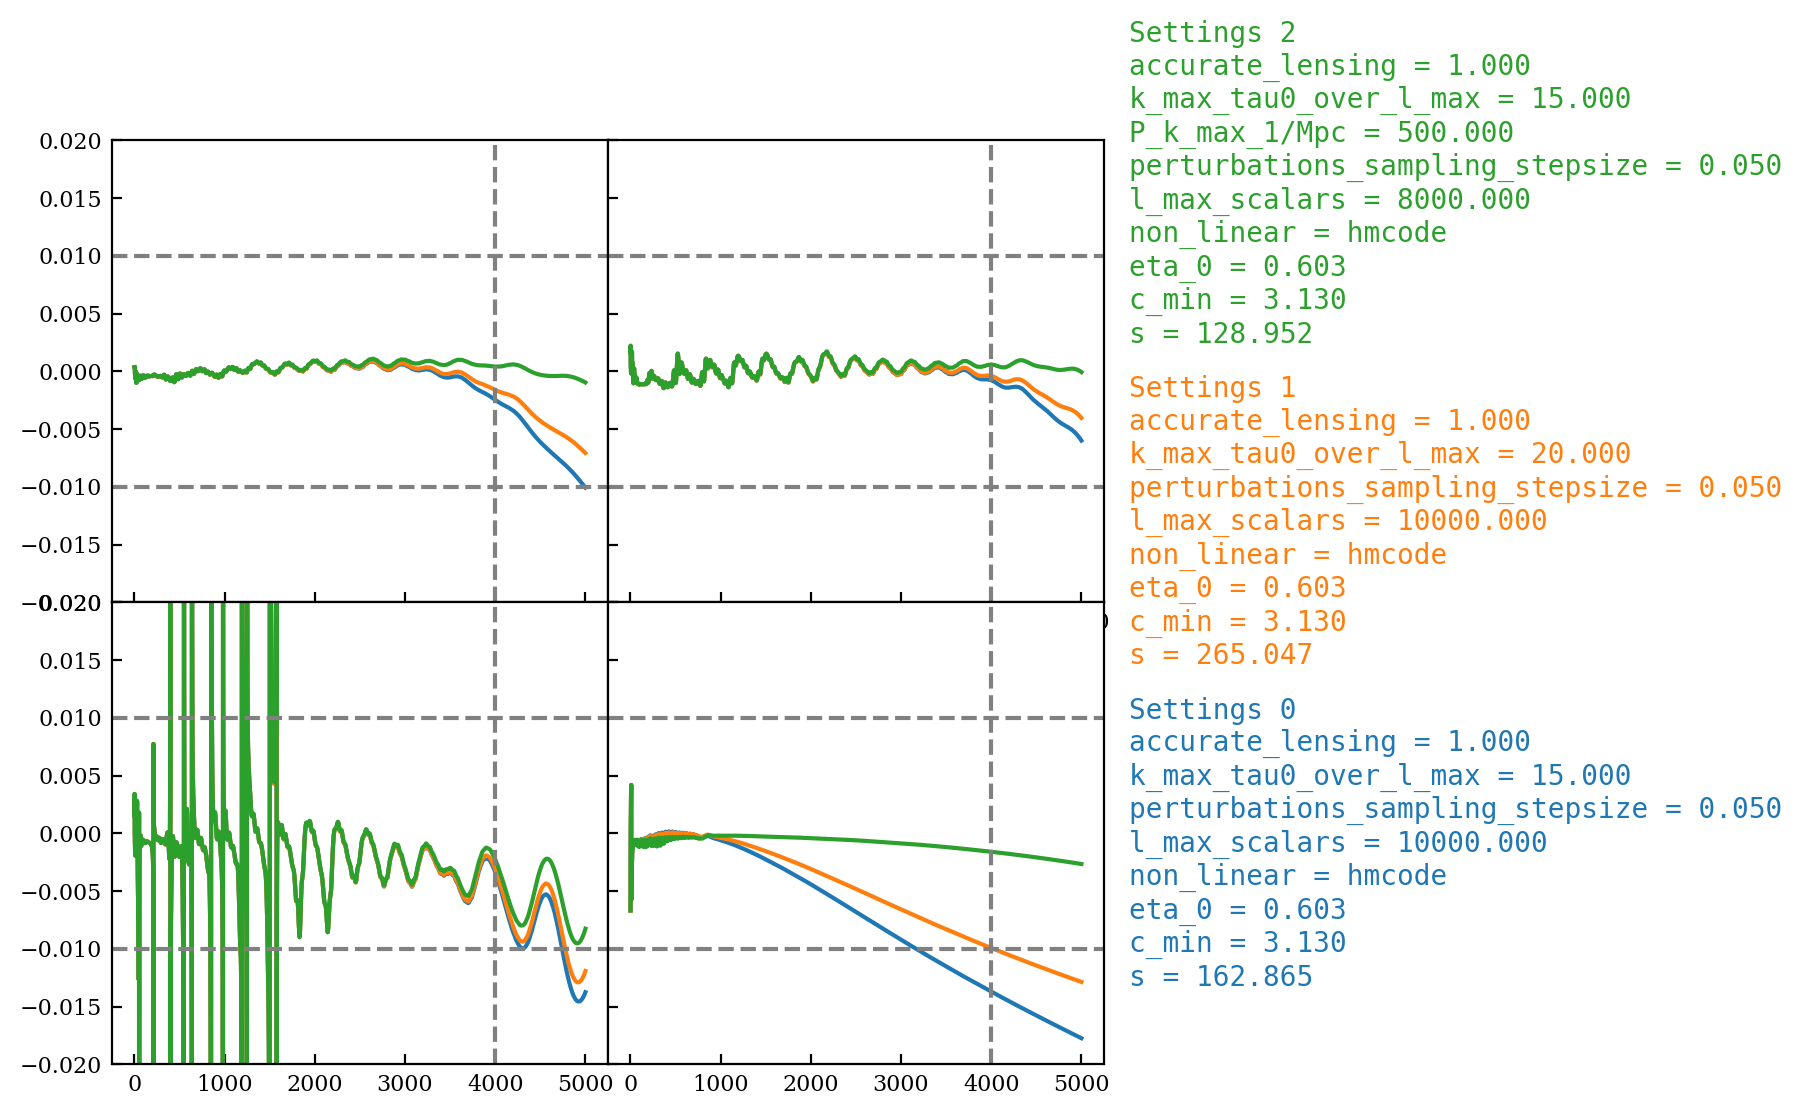

In [555]:
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 10,
    #'text.usetex': True,
    'pgf.rcfonts': False,
})

fig = plt.figure()
iax = error_plots(fig, [boillet, lrange, lrange1], camb_up, ll_max_plot=5000)
print(lrange1)
plt.show()

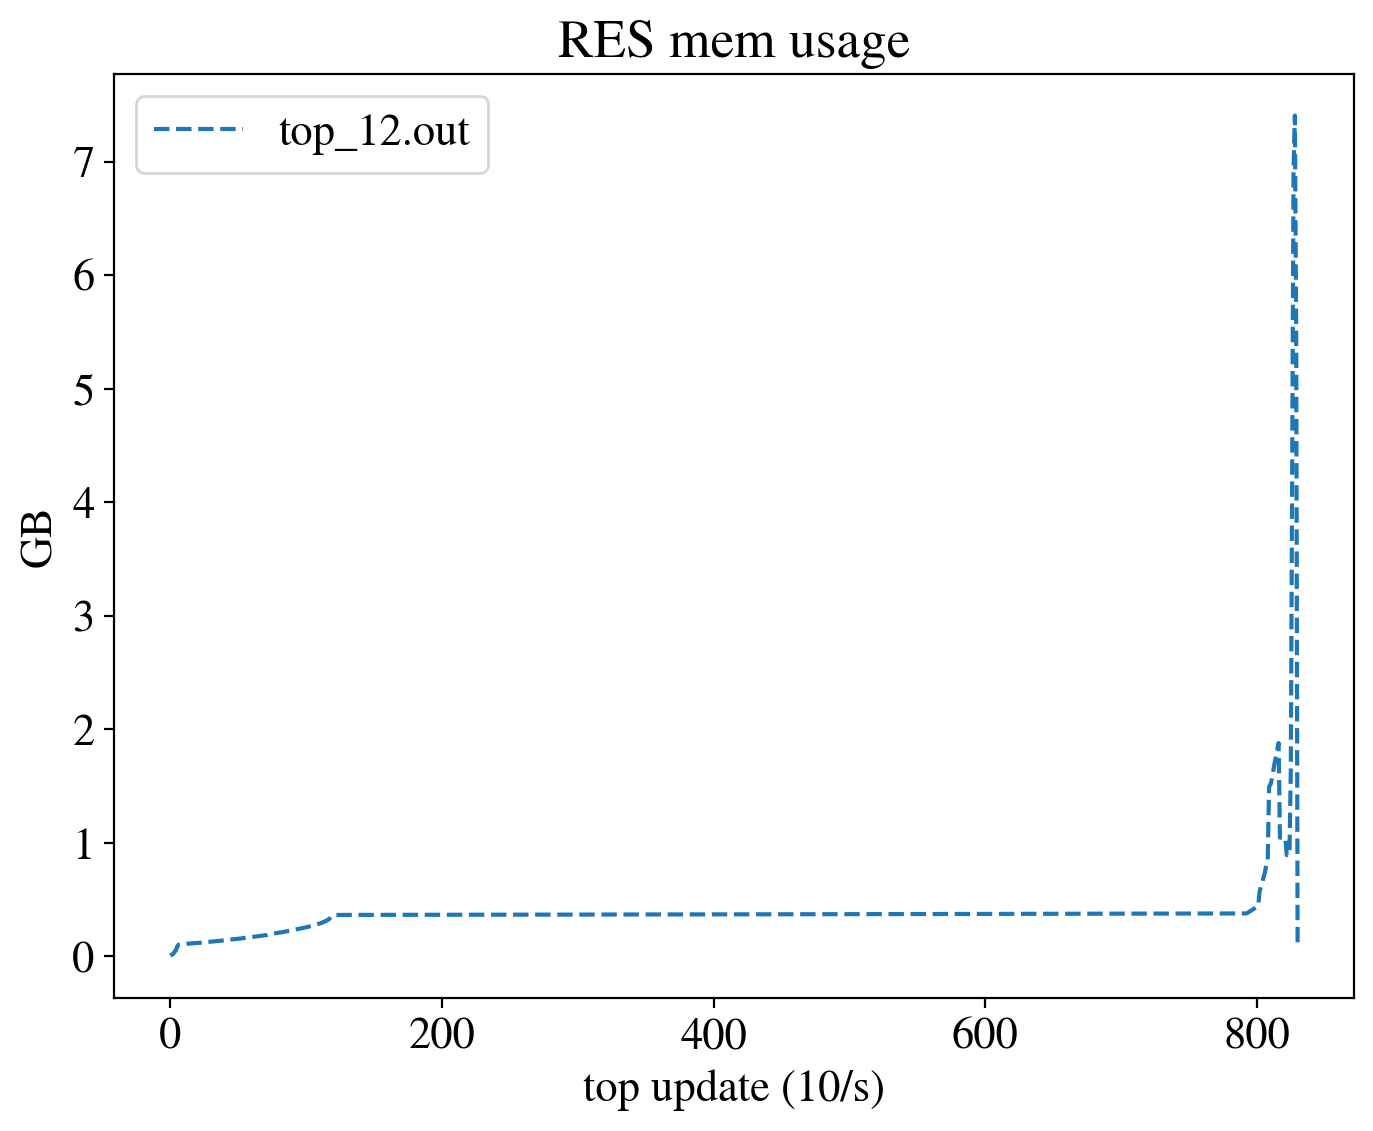

In [5]:

def python_filter(top_out):
    id = np.argwhere(top_out[:,2]=="python")
    return top_out[id,0:2][:,0]

def plot_toplog(ax, file_list, type="virt", linestyle="solid"):

    logs = []
    labels = []
    if type=="virt":
        mem_id = 5
    elif type=="res":
        mem_id = 6
    for filename in file_list:
        logs.append(python_filter(np.loadtxt(filename, dtype="U", usecols=(1,mem_id,12))))
        labels.append(filename.split("/")[-1])


    for i,log in enumerate(logs):
        pid =log[:, 0]
        mem = []
        if type=="res":
            for j in log[:,1]:
                if j.endswith('g'):
                    mem.append(float(j[:-1]))
                elif j.endswith('t'):
                    mem.append(float(j[:-1])*2**10)
                else:
                    mem.append(int(j)/2**20)
        elif type=="virt":
            mem = np.array([int(i) for i in log[:, 1]])
            mem = np.right_shift(mem, 20)
        mem=np.array(mem)
        for p in np.unique(pid):
            unique_idx = np.where(pid==p)[0]
            ax.plot(mem[unique_idx], label="{}".format(labels[i]), linestyle=linestyle)

    ax.set_ylabel("GB")
    ax.set_xlabel("top update (10/s)")
    ax.set_title("{} mem usage".format(type.upper()))
    ax.legend()
    return ax

filelist = ["../top_1.out", "../top_2.out", "../top_3.out", "../top_4.out", "../top_5.out", "../top_6.out", "../top_7.out", "../top_8.out", "../top_9.out"]
filelist = ["../logs/top_12.out"]
fig,ax = plt.subplots()

ax = plot_toplog(ax, filelist, type="res", linestyle="dashed")

plt.show()

# Thread optimization

[[576.82337645   1.        ]
 [432.21386846   2.        ]
 [269.60799722   4.        ]
 [189.16619488   8.        ]
 [166.19897463  12.        ]
 [149.76653664  16.        ]
 [147.02160452  17.        ]
 [132.85906335  32.        ]
 [124.54800359  64.        ]]
A 504.26056114384096
b -0.398252967002607


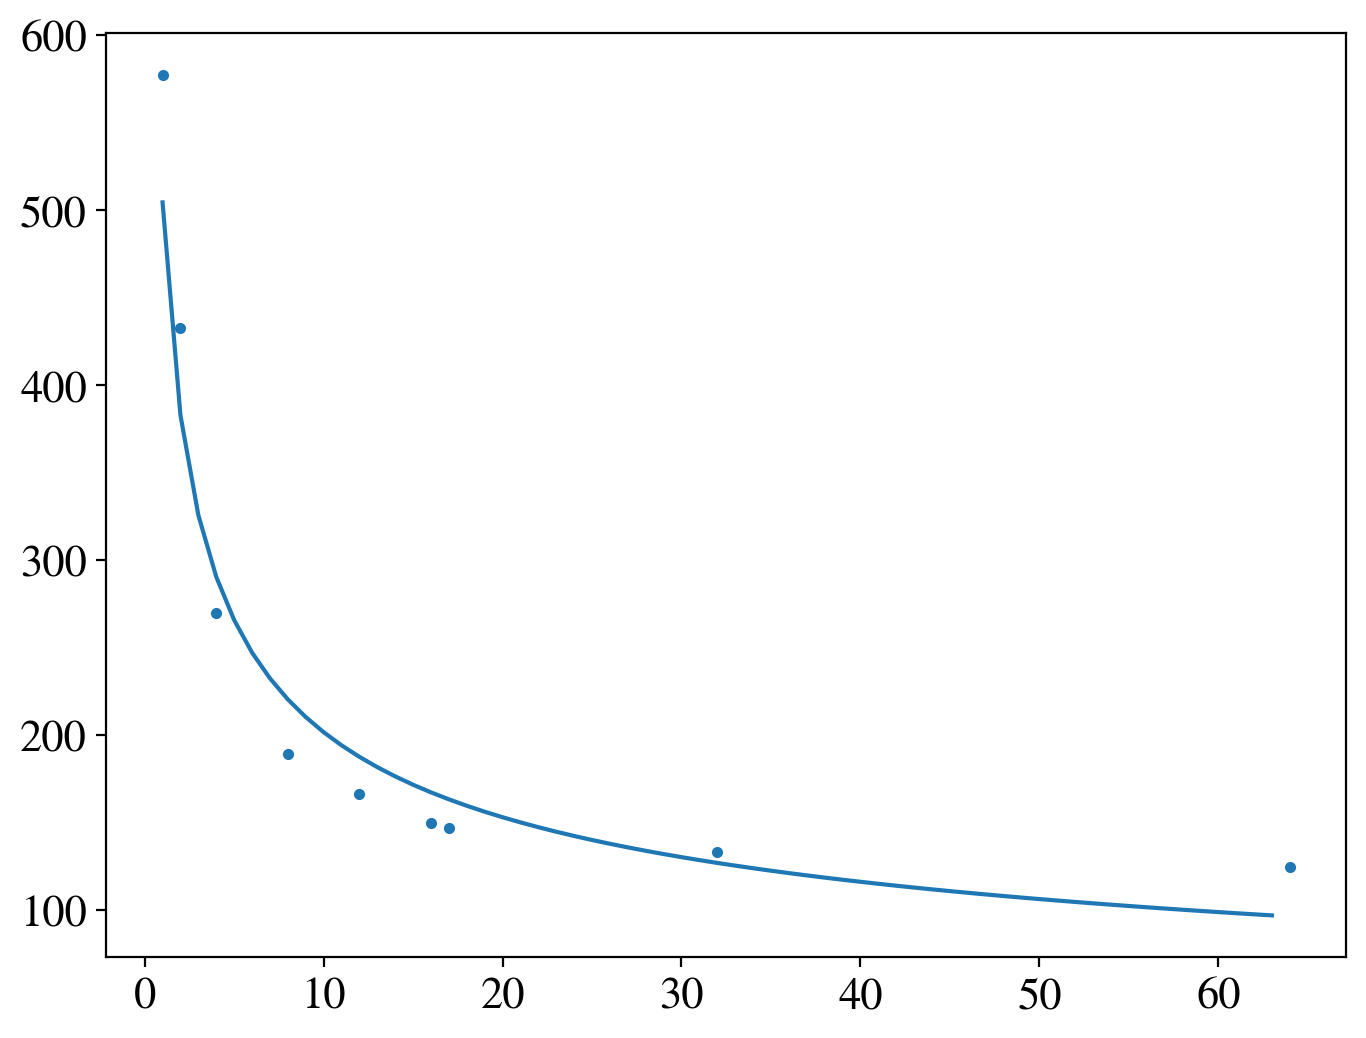

In [4]:
from scipy.optimize import curve_fit

# Fit the function a * np.exp(b * t) + c to x and y

fig, ax = plt.subplots()

timings = np.loadtxt("../data/omp_thread_timings.txt")

timings = timings[timings[:,1].argsort()]
print(timings)
nranks = timings[:,1]
t = timings[:,0]
logN = np.log10(nranks)
logT = np.log10(t)
#popt, pcov = curve_fit(lambda t,a,b,n: a/t + b, nranks, time)
popt = np.polyfit(logN, logT, 1)
A = 10**popt[1]
b = popt[0]

print("A {}".format(A))
print("b {}".format(b))

n = np.arange(1, 64, 1)


ax.scatter(nranks, t, marker=".")
ax.plot(n, A*n**b)
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.plot(x,popt[0]/x**popt[2]+popt[1], label="1/x")


plt.show()

In [5]:
from kneed import KneeLocator
kn = KneeLocator(nranks, t, curve='convex', direction='decreasing')
kn_fit =  KneeLocator(n, A*n**b, curve='convex', direction='decreasing')
print(kn.knee)
print(kn_fit.knee)

8.0
12


(15, 17)
714137.3881606096
556251.696877556


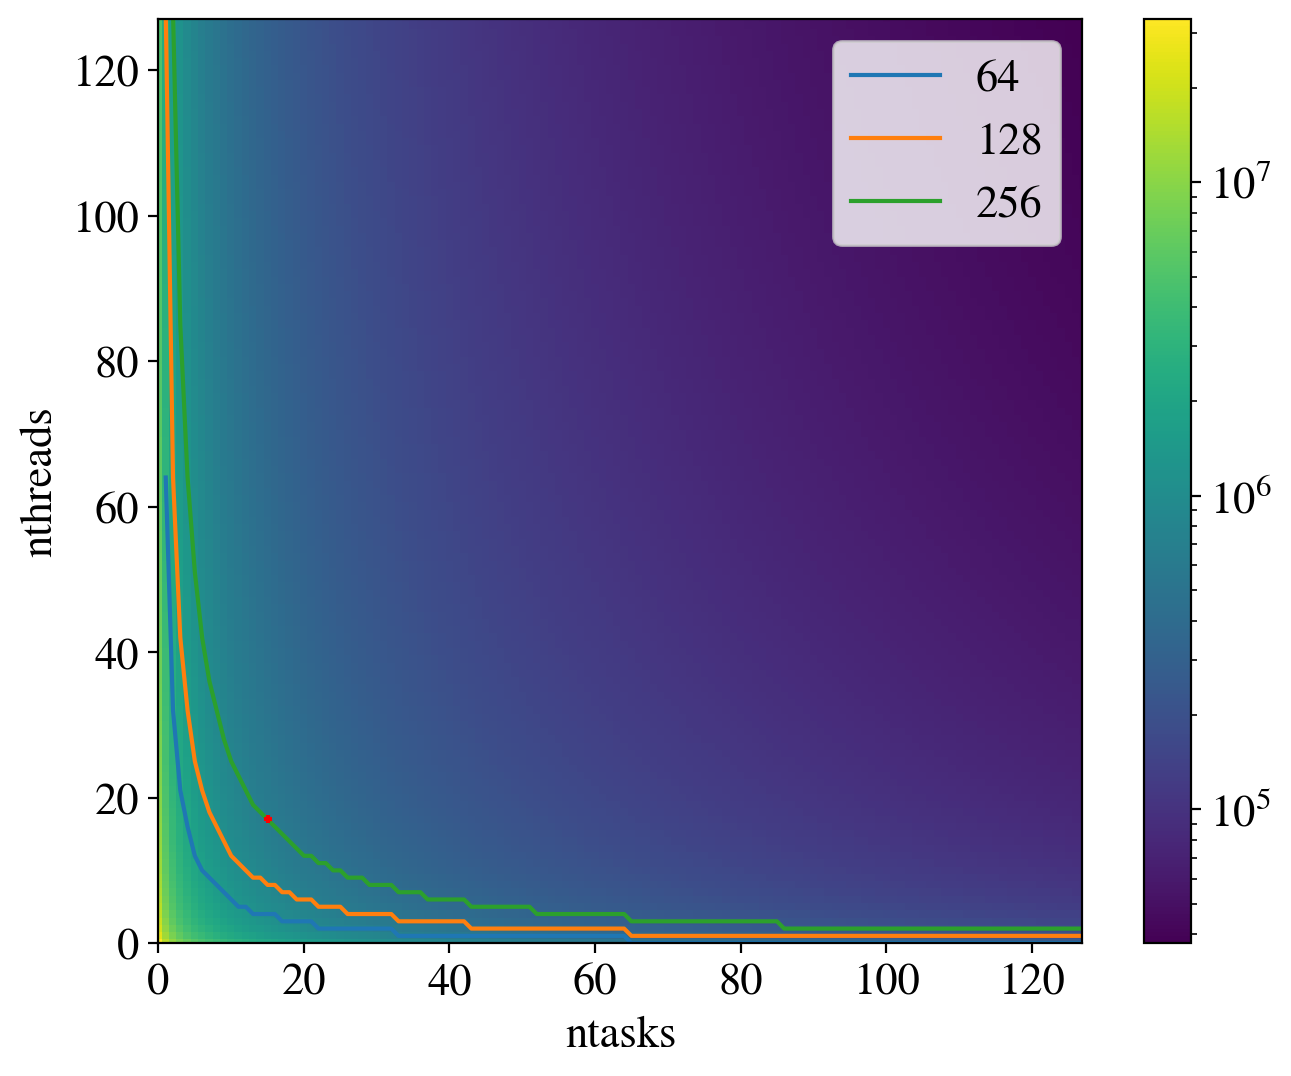

In [7]:
from matplotlib.colors import LogNorm
import itertools
def cost_function(ntask, nthread, N=65652):
    return (N/ntask)*A*nthread**b

grid1d = np.arange(1, 128+1)
xv, yv = np.meshgrid(grid1d, grid1d)

fig,ax = plt.subplots()
times = cost_function(xv, yv)

combos = itertools.combinations(grid1d, r=2)

def constrained_min(total_cpus, num_models=65652):
    valid_points = []
    for point in combos:
        if point[0]*point[1]<=total_cpus:
            valid_points.append(point)
    evals = []
    for p in valid_points:
        evals.append(cost_function(p[0], p[1], N=num_models))
    evals=np.array(evals)
    return valid_points[np.argwhere(evals==evals.min())[0][0]], evals.min()

coord, min = constrained_min(256)
print(coord)
print(min)
print(cost_function(26, 8))
im = ax.matshow(times, cmap=mpl.cm.viridis, norm=LogNorm(vmin=np.min(times.flatten()), vmax=np.max(times.flatten())), origin="upper" )
total_cpus = [64, 128, 256]
for cpu in total_cpus:
    ax.plot(grid1d, np.floor(cpu/grid1d), label=cpu)
ax.set_xlim([0, 127])
ax.set_ylim([0, 127])
ax.set_xlabel("ntasks")
ax.set_ylabel("nthreads")
ax.xaxis.set_ticks_position('bottom')
ax.scatter(*coord, marker="+", s=8, zorder=2, color="red")
plt.colorbar(im)
ax.legend(loc = "upper right")
plt.show()


In [11]:
35539.08176439015/60/60

9.87196715677504

In [556]:
print(timings)

[[1.86022333e+03 1.00000000e+00]
 [1.30497452e+03 2.00000000e+00]
 [7.26538363e+02 4.00000000e+00]
 [4.37014627e+02 8.00000000e+00]
 [3.76011504e+02 1.00000000e+01]
 [2.92960813e+02 1.60000000e+01]
 [2.20369874e+02 3.20000000e+01]
 [1.93037483e+02 6.40000000e+01]]


In [563]:
nt = [2**n for n in np.arange(8)]
print(nt)
for i in nt:
    print("{} threads require {}M per thread".format(i, 8000./i))

[1, 2, 4, 8, 16, 32, 64, 128]
1 threads require 8000.0M per thread
2 threads require 4000.0M per thread
4 threads require 2000.0M per thread
8 threads require 1000.0M per thread
16 threads require 500.0M per thread
32 threads require 250.0M per thread
64 threads require 125.0M per thread
128 threads require 62.5M per thread


In [12]:
8000/12

666.6666666666666

In [14]:
cost_function(9, 12, N=1896)/60/60

10.968852396416713